# My Music Taste 👨‍🎤🍷

[GitHub](https://github.com/mpb9/audio/exportify) | [Jupyter Lab editor](http://localhost:8888/lab/tree/exportify/taste.ipynb)

*based on the [Exportify](https://exportify.net/) creator's [Taste Analysis](https://exportify.net/taste_analysis)*

## exportify/[taste_analysis.ipynb](https://github.com/pavelkomarov/exportify/blob/master/taste_analysis.ipynb)

### How to Use

> My first pass at this depended upon [Watsonbox's Exportify](https://github.com/watsonbox/exportify), but I decided I didn't like his version because of bugs and inadequate output detail. So I [went and forked it](https://github.com/pavelkomarov/exportify), cleaned up the code, and hosted it myself.
>
> As such, the code here depends on `.csv` inputs in the format output by my version.
>
> 1. To get started, hop on ofilename = 'music_that_tickles_my_fancy.csv'
> 2. Next, either download this `.ipynb` file and run the notebook yourself or [launch it in Binder](https://mybinder.org/v2/gh/pavelkomarov/exportify/master).
> 3. Either put the downloaded `.csv` in the same directory as the notebook, or upload it in Binder.
> 4. Open the `.ipynb` through your browser, update the `filename` variable in the first code cell to point to your playlist instead, and `shift+enter` in each following code cell to generate the corresponding plot. (Or select `Cell -> Run` All from the menu to make all graphs at once.)

## 🛠️

In [155]:
from matplotlib import pyplot
import seaborn
import pandas
from collections import defaultdict
from scipy.stats import pareto, gamma
from datetime import date

In [156]:
directory = "../data/spotify_playlists/"
file_path = directory + "liked_songs.csv"
data = pandas.read_csv(file_path)

playlist_name = file_path.split("/")[-1].split(".")[0].replace("_", " ")

print("total songs in '" + playlist_name + "' :", data.shape[0])

total songs in 'liked songs' : 1486


## Artist Bar Chart

Number of songs binned by artist.

number of unique artists: 774


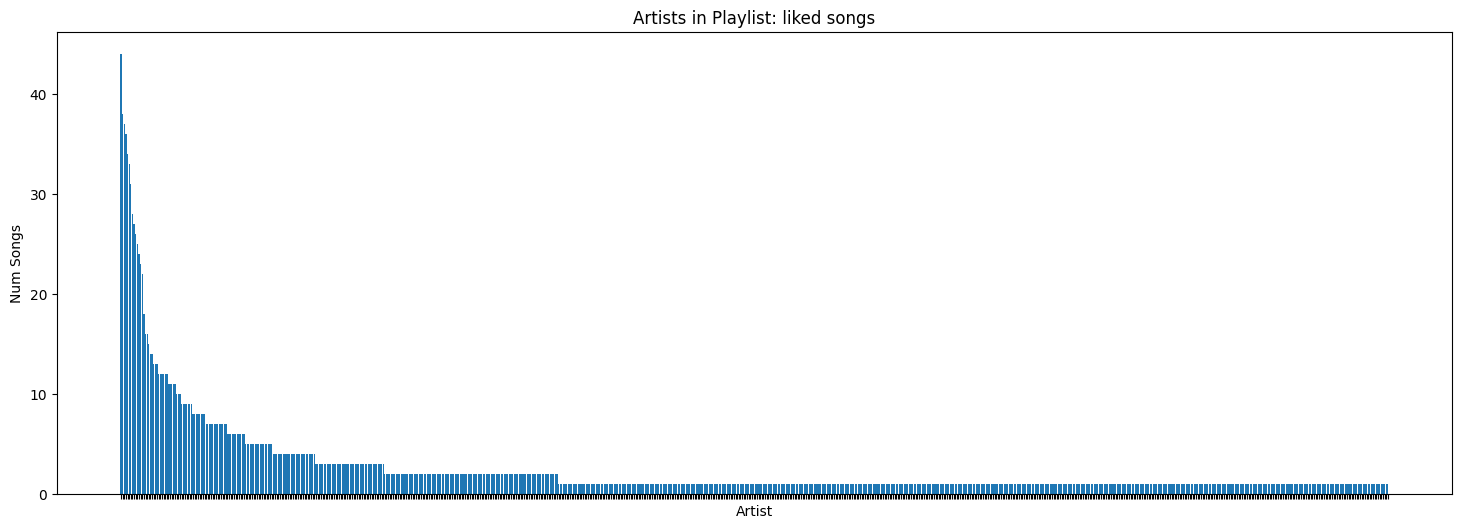

In [157]:
artists = defaultdict(int)

for i, song in data.iterrows():
    if isinstance(song["Artist Name(s)"], str):
        for musician in song["Artist Name(s)"].split(","):
            artists[musician] += 1

# sort for chart
artists = (
    pandas.DataFrame(artists.items(), columns=["Artist", "Num Songs"])
    .sort_values("Num Songs", ascending=False)
    .reset_index(drop=True)
)
print("number of unique artists:", artists.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists["Artist"], artists["Num Songs"])
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("Artists in Playlist: " + playlist_name)
pyplot.show()

Text(0.5, 1.0, 'Artists in Playlist: liked songs')

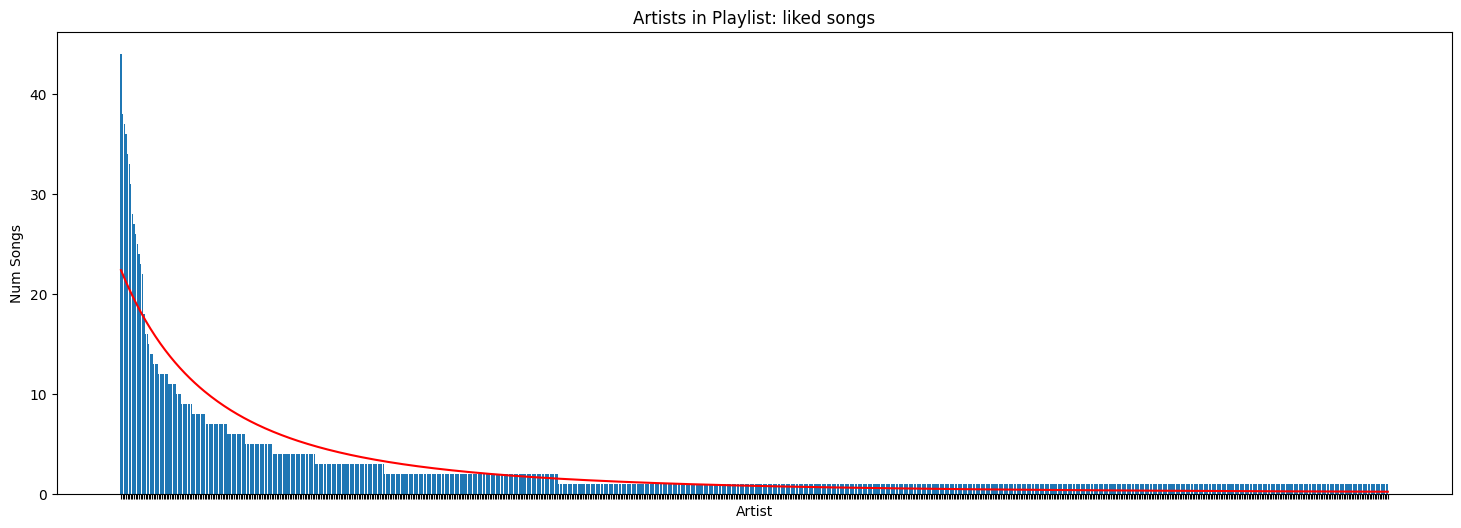

In [158]:
# Let's find the best parameters. Need x, y data 'sampled' from the distribution for parameter fit.
y = []
for i in range(artists.shape[0]):
    for j in range(artists["Num Songs"][i]):
        y.append(i)  # just let y have index[artist] repeated for each song

# sanity check. If the dataframe isn't sorted properly, y isn't either.
# pyplot.figure()
# pyplot.hist(y, bins=30)

# The documentation is pretty bad, but this is okay:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

param = pareto.fit(y, 100)
pareto_fitted = len(y) * pareto.pdf(range(artists.shape[0]), *param)
# param = gamma.fit(y) # gamma fits abysmally; see for yourself by uncommenting
# gamma_fitted = len(y)*gamma.pdf(range(artists.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists["Artist"], artists["Num Songs"])
pyplot.plot(pareto_fitted, color="r")
# pyplot.plot(gamma_fitted, color='g')
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("Artists in Playlist: " + playlist_name)

Text(0.5, 1.0, 'Top 50 Artists in Playlist: liked songs')

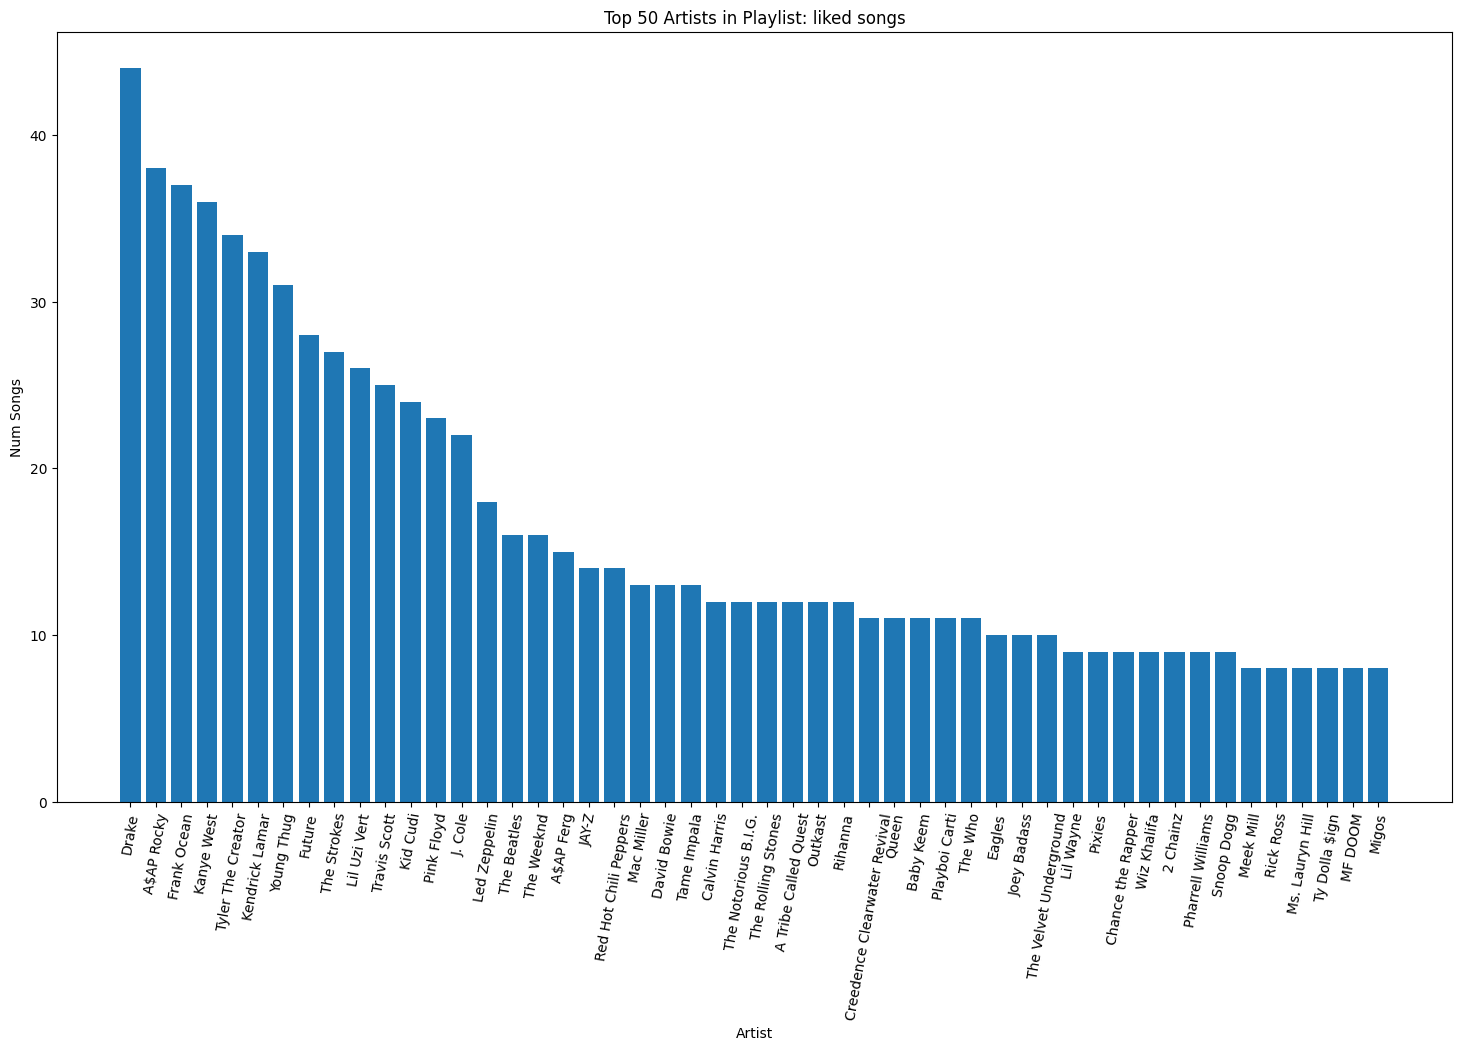

In [159]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(artists["Artist"][:50], artists["Num Songs"][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("Top 50 Artists in Playlist: " + playlist_name)

## Volume Added Over Time

My proclivity to add songs to this playlist is a proxy for my interest in listening to music generally. How has it waxed and waned over time?

Text(0.5, 1.0, "volume added to 'liked songs' over time")

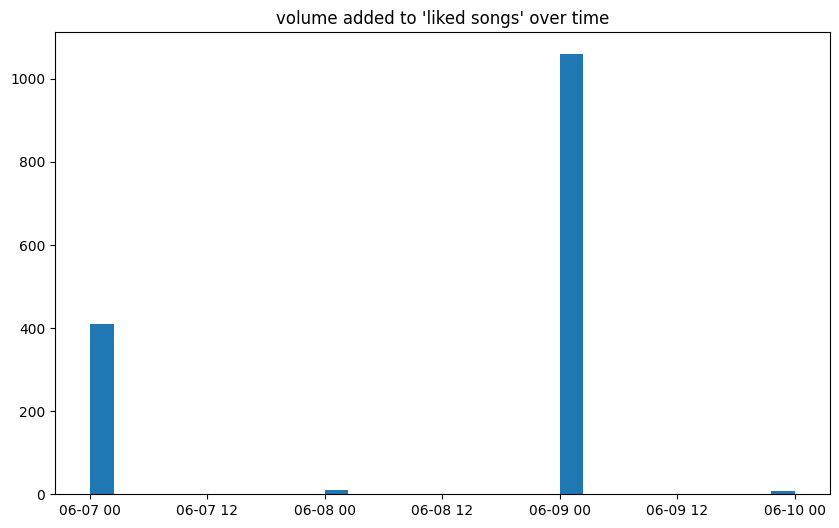

In [160]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()  # to suppress warning

# Plot of added volume over time
parse_date = lambda d: (int(d[:4]), int(d[5:7]), int(d[8:10]))
pyplot.figure(figsize=(10, 6))
pyplot.hist([date(*parse_date(d)) for d in data["Added At"]], bins=30)
pyplot.title("volume added to '"  + file_path.split("/")[-1].split(".")[0].replace("_", " ") + "' over time")

## Eclecticness Measure (Frequency Transform)

This one is a personal favorite. I want to know how many of my songs are one-offs from that artist for me--just individual pieces I found fantastic and ended up adding after a few listens--, how many are two-offs, et cetera. I know it must be heavily skewed toward the low numbers.

number of song-artist pairs represented in the eclecticness chart: 2035


Text(0, 0.5, 'Volume')

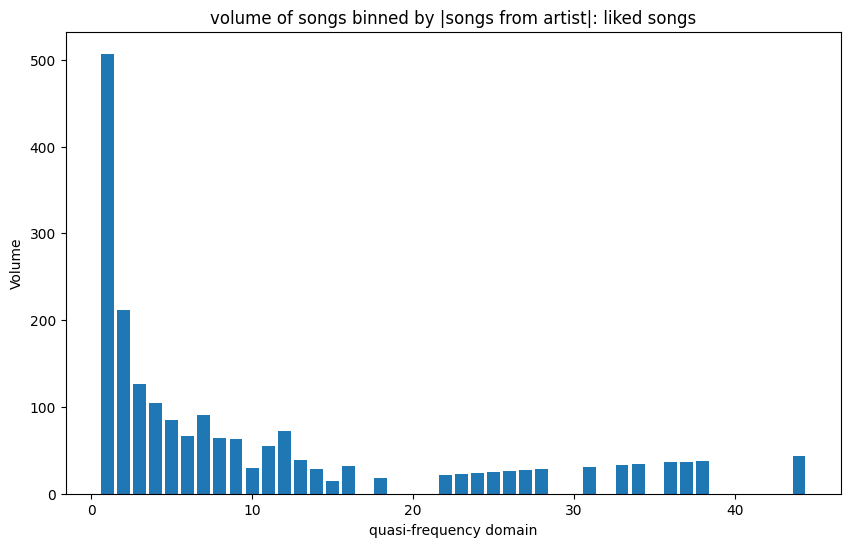

In [161]:
# bar chart of first bar chart == hipster diversity factor
frequency = defaultdict(int)
for n in artists["Num Songs"]:
    frequency[n] += n
frequency = pandas.DataFrame(
    frequency.items(), columns=["Unique Count", "Volume"]
).sort_values("Volume", ascending=False)
print(
    "number of song-artist pairs represented in the eclecticness chart:",
    sum(frequency["Volume"]),
)

pyplot.figure(figsize=(10, 6))
pyplot.bar(frequency["Unique Count"].values, frequency["Volume"].values)
pyplot.title("volume of songs binned by |songs from artist|: " + playlist_name)
pyplot.xlabel("quasi-frequency domain")
pyplot.ylabel(frequency.columns[1])

So, yes, it's much more common for an artist to make it in my list a few times than many times. In fact, the plurality of my top songs come from unique artists.

Conversely, this view also makes stark those few musicians from whom I've collected dozens.

Note that here, as in the artist bar charts, some songs are doubly-counted, because in cases artists collaborated I listed the song in both bins.

## Genres Bar Chart

Alright, enough messing around. All the above were possible with the output from Watsonbox's Exportify. Let's get to the novel stuff you came here for.

People describe music by genre. As we'll see, genre names are flippin' hilarious and extremely varied, but in theory if I cluster around a few, that should give you a flavor of my tastes.

number of unique genres: 228


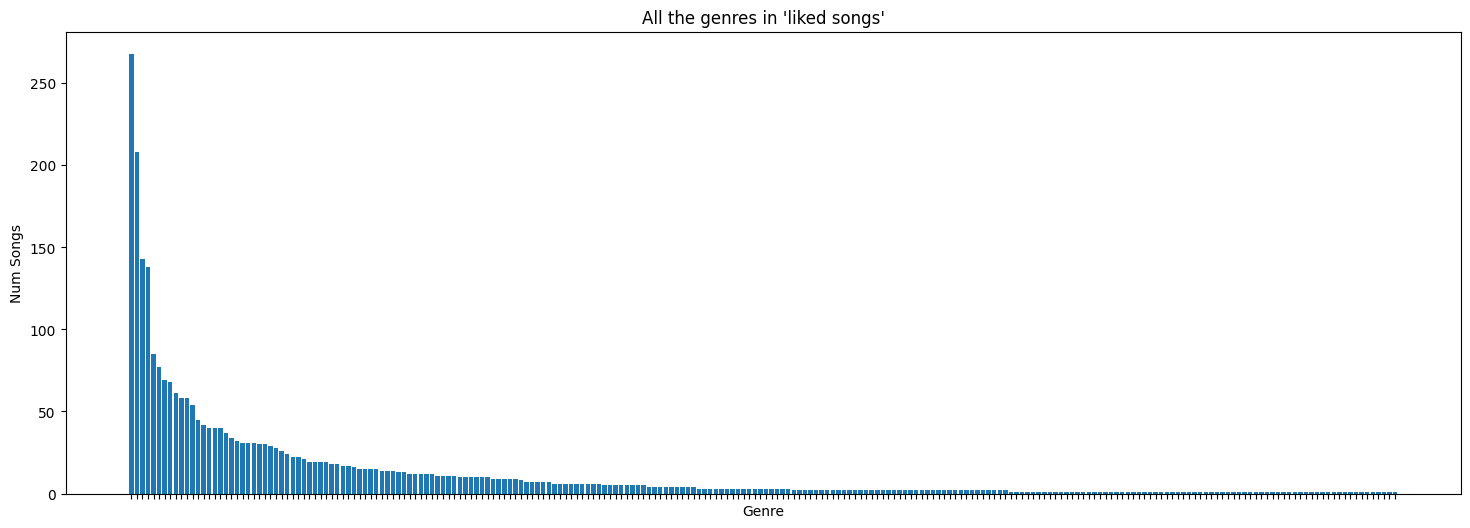

In [162]:
# count songs per genre
genres = defaultdict(int)
for i,song in data.iterrows():
    if type(song['Genres']) is str: # some times there aren't any, and this is NaN
        for genre in song['Genres'].split(','):
            if len(genre) > 0: # empty string seems to be a legit genre
                genres[genre] += 1

# sort for chart
genres = pandas.DataFrame(genres.items(), columns=['Genre', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique genres:", genres.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("All the genres in '" + playlist_name + "'");

So many! Let's do the same thing as with the artists and for giggles see if it fits a power law.

Text(0.5, 1.0, "All the genres in 'liked songs' with Pareto fit")

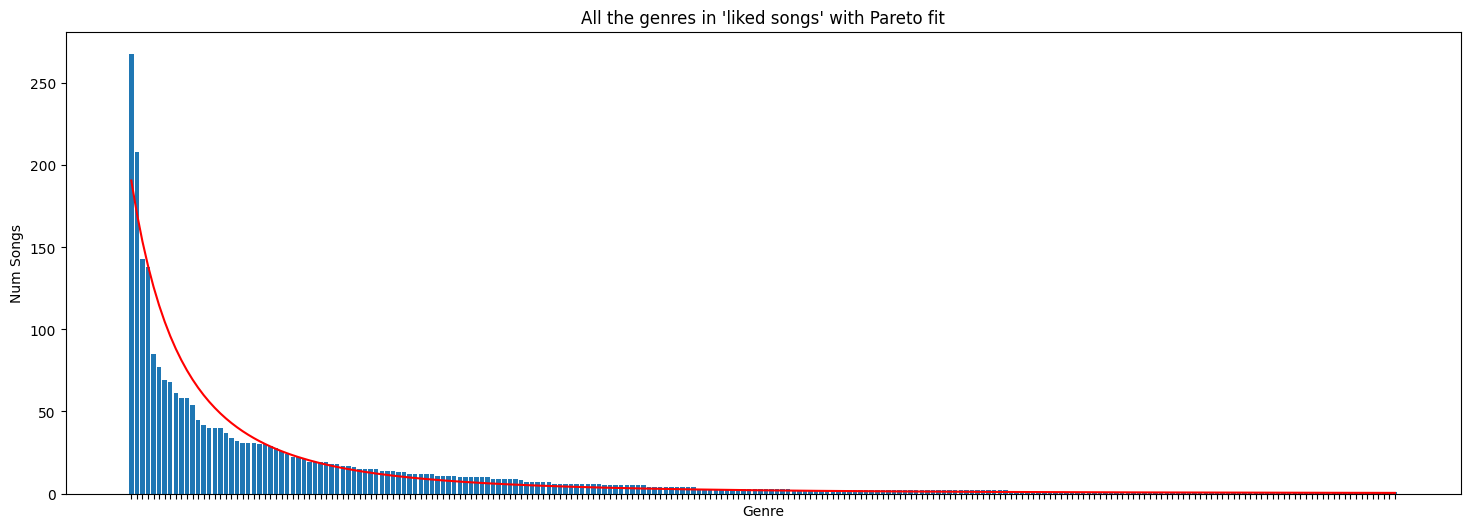

In [163]:
y = []
for i in range(genres.shape[0]):
	for j in range(genres['Num Songs'][i]):
		y.append(i) 

# sanity check
#pyplot.figure()
#pyplot.hist(y, bins=30)

param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(genres.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres['Num Songs'])
pyplot.plot(pareto_fitted, color='r')
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("All the genres in '" + playlist_name + "' with Pareto fit")

Still too sharp, but fits better than with the artists.

Let's look at the top 50 so we can read the names.

Text(0.5, 1.0, "Top 50 Genres in 'liked songs'")

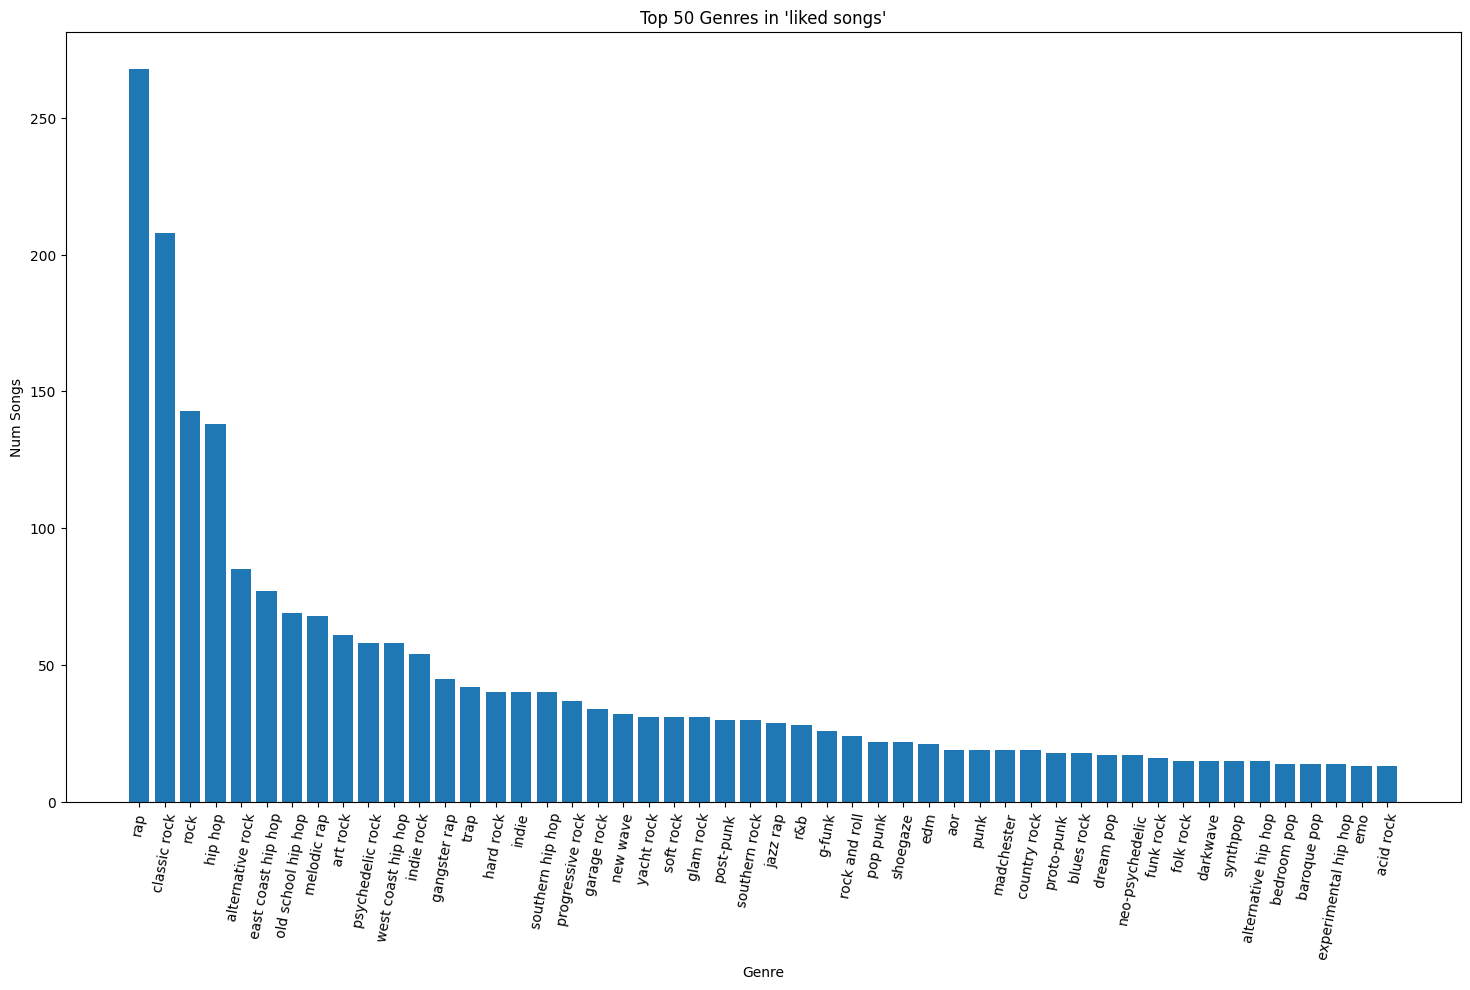

In [164]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(genres['Genre'][:50], genres['Num Songs'][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Top 50 Genres in '" + playlist_name + "'")

Text(0.5, 1.0, "Bottom 50 Genres in 'liked songs'")

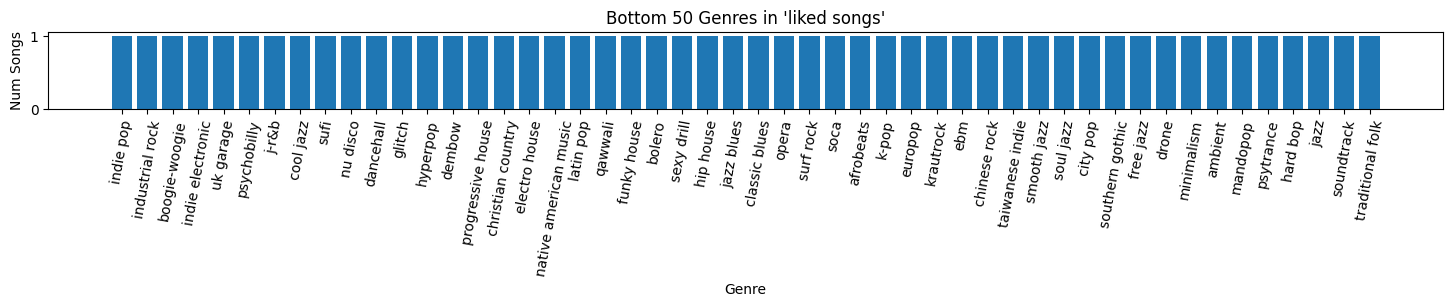

In [165]:
pyplot.figure(figsize=(18, 1))
pyplot.bar(genres['Genre'][-50:], genres['Num Songs'][-50:])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Bottom 50 Genres in '" + playlist_name + "'")

## Release Dates

Which era of music do I prefer?

Text(0.5, 1.0, 'Songs per year in "liked songs"')

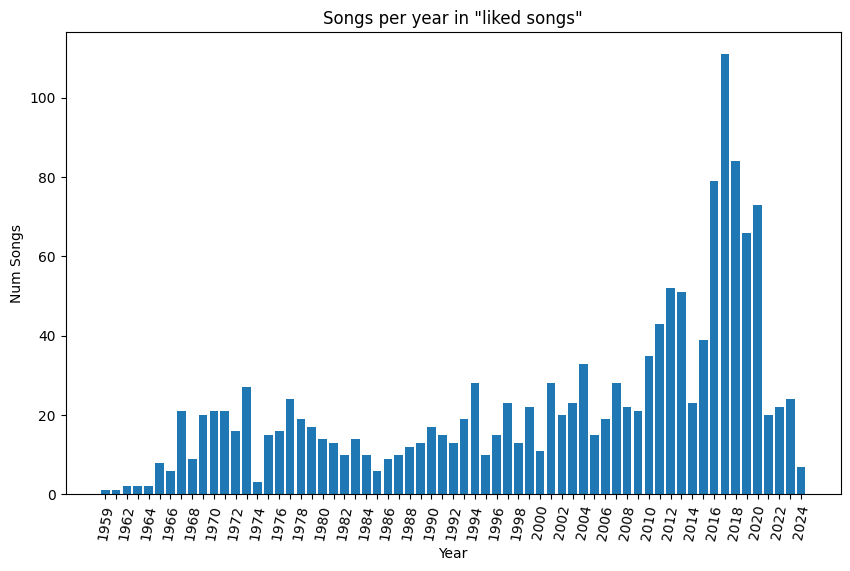

In [166]:
years = defaultdict(int)
for i,song in data.iterrows():
    if isinstance(song['Release Date'], str): #  somebody found a NaN release date!
        years[song['Release Date'][:4]] += 1

years = pandas.DataFrame(years.items(), columns=['Year', 'Num Songs']
                          ).sort_values('Year')

pyplot.figure(figsize=(10, 6))
pyplot.bar(years['Year'], years['Num Songs'])
pyplot.xticks(years['Year'], [y if i % 2 == 0 else '' for i,y in enumerate(years['Year'])], rotation=80)
pyplot.xlabel(years.columns[0])
pyplot.ylabel(years.columns[1])
pyplot.title('Songs per year in "' + playlist_name + '"')

Oldest Hall of Fame
                                     Track Name  \
143                            Shout Pts. 1 & 2   
555                                    Emotions   
108                                Monster Mash   
144                                 Stand By Me   
145           Twist And Shout - Remastered 2009   
13   I Saw Her Standing There - Remastered 2009   
551                                 Stand by Me   
903               The Times They Are A-Changin'   
550                               It's Too Late   
85                              She's Not There   

                            Artist Name(s) Release Date  
143                     The Isley Brothers   1959-08-21  
555                             Brenda Lee   1961-04-03  
108  Bobby Boris Pickett,The Crypt-Kickers   1962-01-01  
144                            Ben E. King   1962-08-20  
145                            The Beatles   1963-03-22  
13                             The Beatles   1963-03-22  
551         

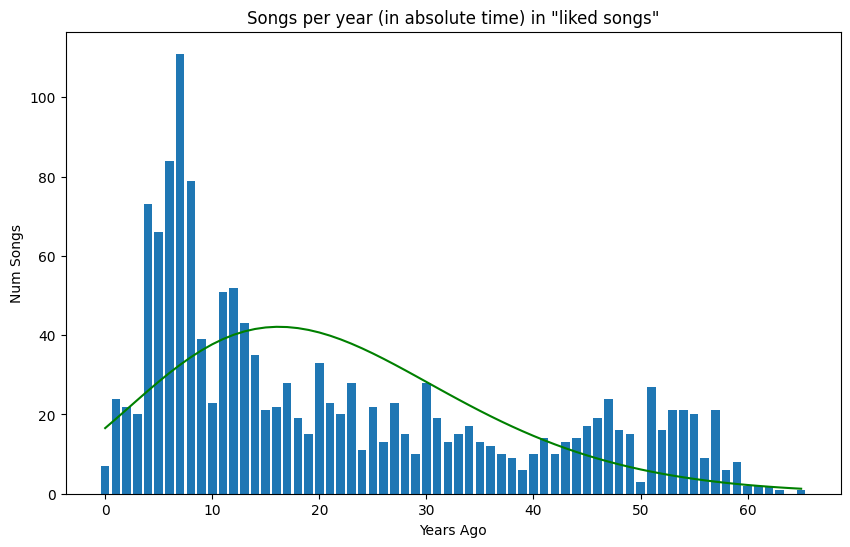

In [167]:
# Some years are missing, so transform to a dataframe that covers full time period.
eldest = int(years['Year'].values[0])
youngest = int(years['Year'].values[-1])
missing_years = [str(x) for x in range(eldest+1, youngest) if
                 str(x) not in years['Year'].values]
ago = pandas.concat((years, pandas.DataFrame.from_dict(
    {'Year': missing_years, 'Num Songs': [0 for x in range(len(missing_years))]})
                  )).sort_values('Year', ascending=False).reset_index(drop=True)

y = []
for i in range(ago.shape[0]):
	for j in range(int(ago['Num Songs'][i])):
		y.append(i)

# sanity check histogram to make sure I'm constructing y properly
#pyplot.figure()
#pyplot.hist(y, bins=30)
        
param = gamma.fit(y, 10000)
gamma_fitted = len(y)*gamma.pdf(range(ago.shape[0]), *param)

pyplot.figure(figsize=(10, 6))
pyplot.bar(range(len(ago['Year'])), ago['Num Songs'])
pyplot.plot(gamma_fitted, color='g')
pyplot.xlabel('Years Ago')
pyplot.ylabel(ago.columns[1])
pyplot.title('Songs per year (in absolute time) in "' + playlist_name + '"')

print('Oldest Hall of Fame')
print(data[['Track Name', 'Artist Name(s)', 'Release Date']].sort_values(
    'Release Date')[:10])

## Popularity

I was happy to find popularity listed as a field in Spotify's track JSON. It's a percentile between 0 and 100, rather than an absolute number of plays. Still, it can be used to give a notion of how hipster I am.

Average song popularity:  47.473118279569896
Median song popularity:  48.0
Max song popularity:  94


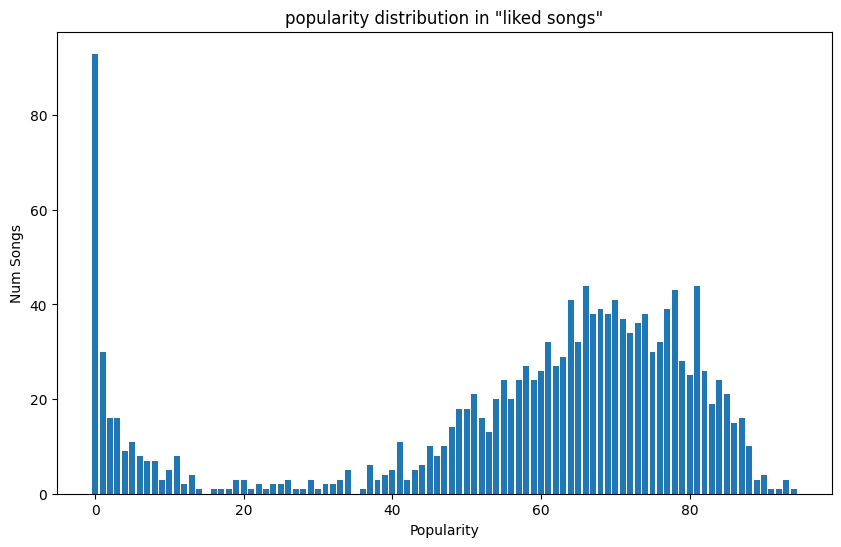

In [168]:
popularity = defaultdict(int)
for i,song in data.iterrows():
    popularity[song['Popularity']] += 1

popularity = pandas.DataFrame(popularity.items(), columns=['Popularity', 'Num Songs']
                          ).sort_values('Popularity')

pyplot.figure(figsize=(10, 6))
pyplot.bar(popularity['Popularity'].values, popularity['Num Songs'].values)
pyplot.xlabel(popularity.columns[0])
pyplot.ylabel(popularity.columns[1])
pyplot.title('popularity distribution in "' + playlist_name + '"')

print("Average song popularity: ", popularity['Popularity'].mean())
print("Median song popularity: ", popularity['Popularity'].median())
print("Max song popularity: ", popularity['Popularity'].max())

## Track Duration

Average song length: 4:05.2513270524898985
Median song length: 3:53.406499999999994


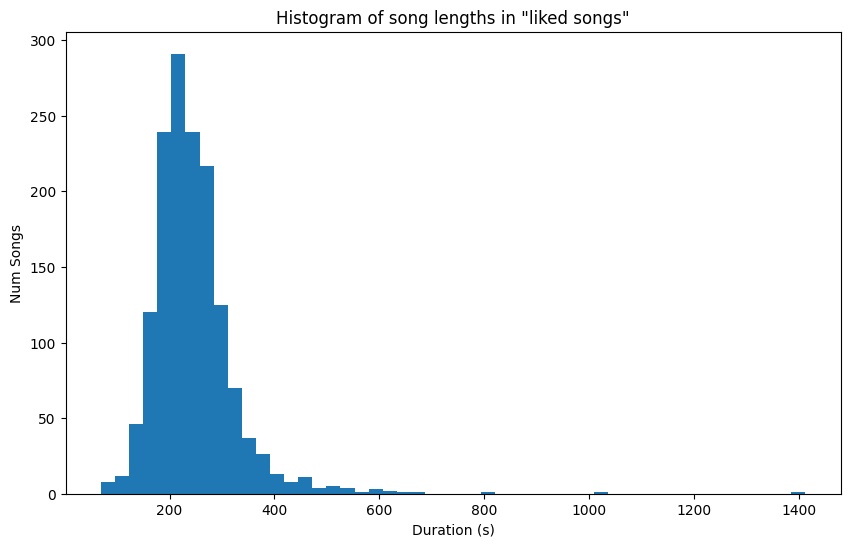

In [169]:
pyplot.figure(figsize=(10,6))
pyplot.hist(data['Duration (ms)']/1000, bins=50);
pyplot.xlabel('Duration (s)')
pyplot.ylabel('Num Songs')
pyplot.title('Histogram of song lengths in "' + playlist_name + '"')

mean = data['Duration (ms)'].mean()/1000
median = data['Duration (ms)'].median()/1000
print("Average song length: " + str(int(mean//60)) + (":" if mean%60 >=10 else ":0")
      + str(mean%60))
print("Median song length: " + str(int(median//60)) + (":" if median%60 >=10 else ":0")
      + str(median%60))

In [170]:
print("Longest Hall of Fame:")
print(data[['Track Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)']].sort_values(
    'Duration (ms)', ascending=False)[:10])

Longest Hall of Fame:
                                             Track Name    Artist Name(s)  \
1117                                             Echoes        Pink Floyd   
975                                                Dogs        Pink Floyd   
1107              Shine On You Crazy Diamond (Pts. 1-5)        Pink Floyd   
976                         Pigs (Three Different Ones)        Pink Floyd   
1202                                              Oldie        Odd Future   
522                                               Sheep        Pink Floyd   
665                                          Hallogallo              NEU!   
926   The Court Of The Crimson King - Including The ...      King Crimson   
65                                             Pyramids       Frank Ocean   
575           California One / Youth and Beauty Brigade  The Decemberists   

     Release Date  Duration (ms)  
1117   1971-11-11        1412451  
975    1977-01-23        1025280  
1107   1975-09-12        

## Musical Features

In the interest of understanding user tastes and providing the best possible music recommendations, Spotify has done some really [sophisticated analysis](http://benanne.github.io/2014/08/05/spotify-cnns.html) of actual track content, which has only gotten more extensive in recent years. Music is a time series, but most similarity metrics (and most ML methods generally) require inputs to be vectors, that is: points in some feature-space. So they've transformed the tracks to numerical metrics like Energy and Valence (continuous) and Key (discrete).

For the continuous metrics, here are distributions for my songs:

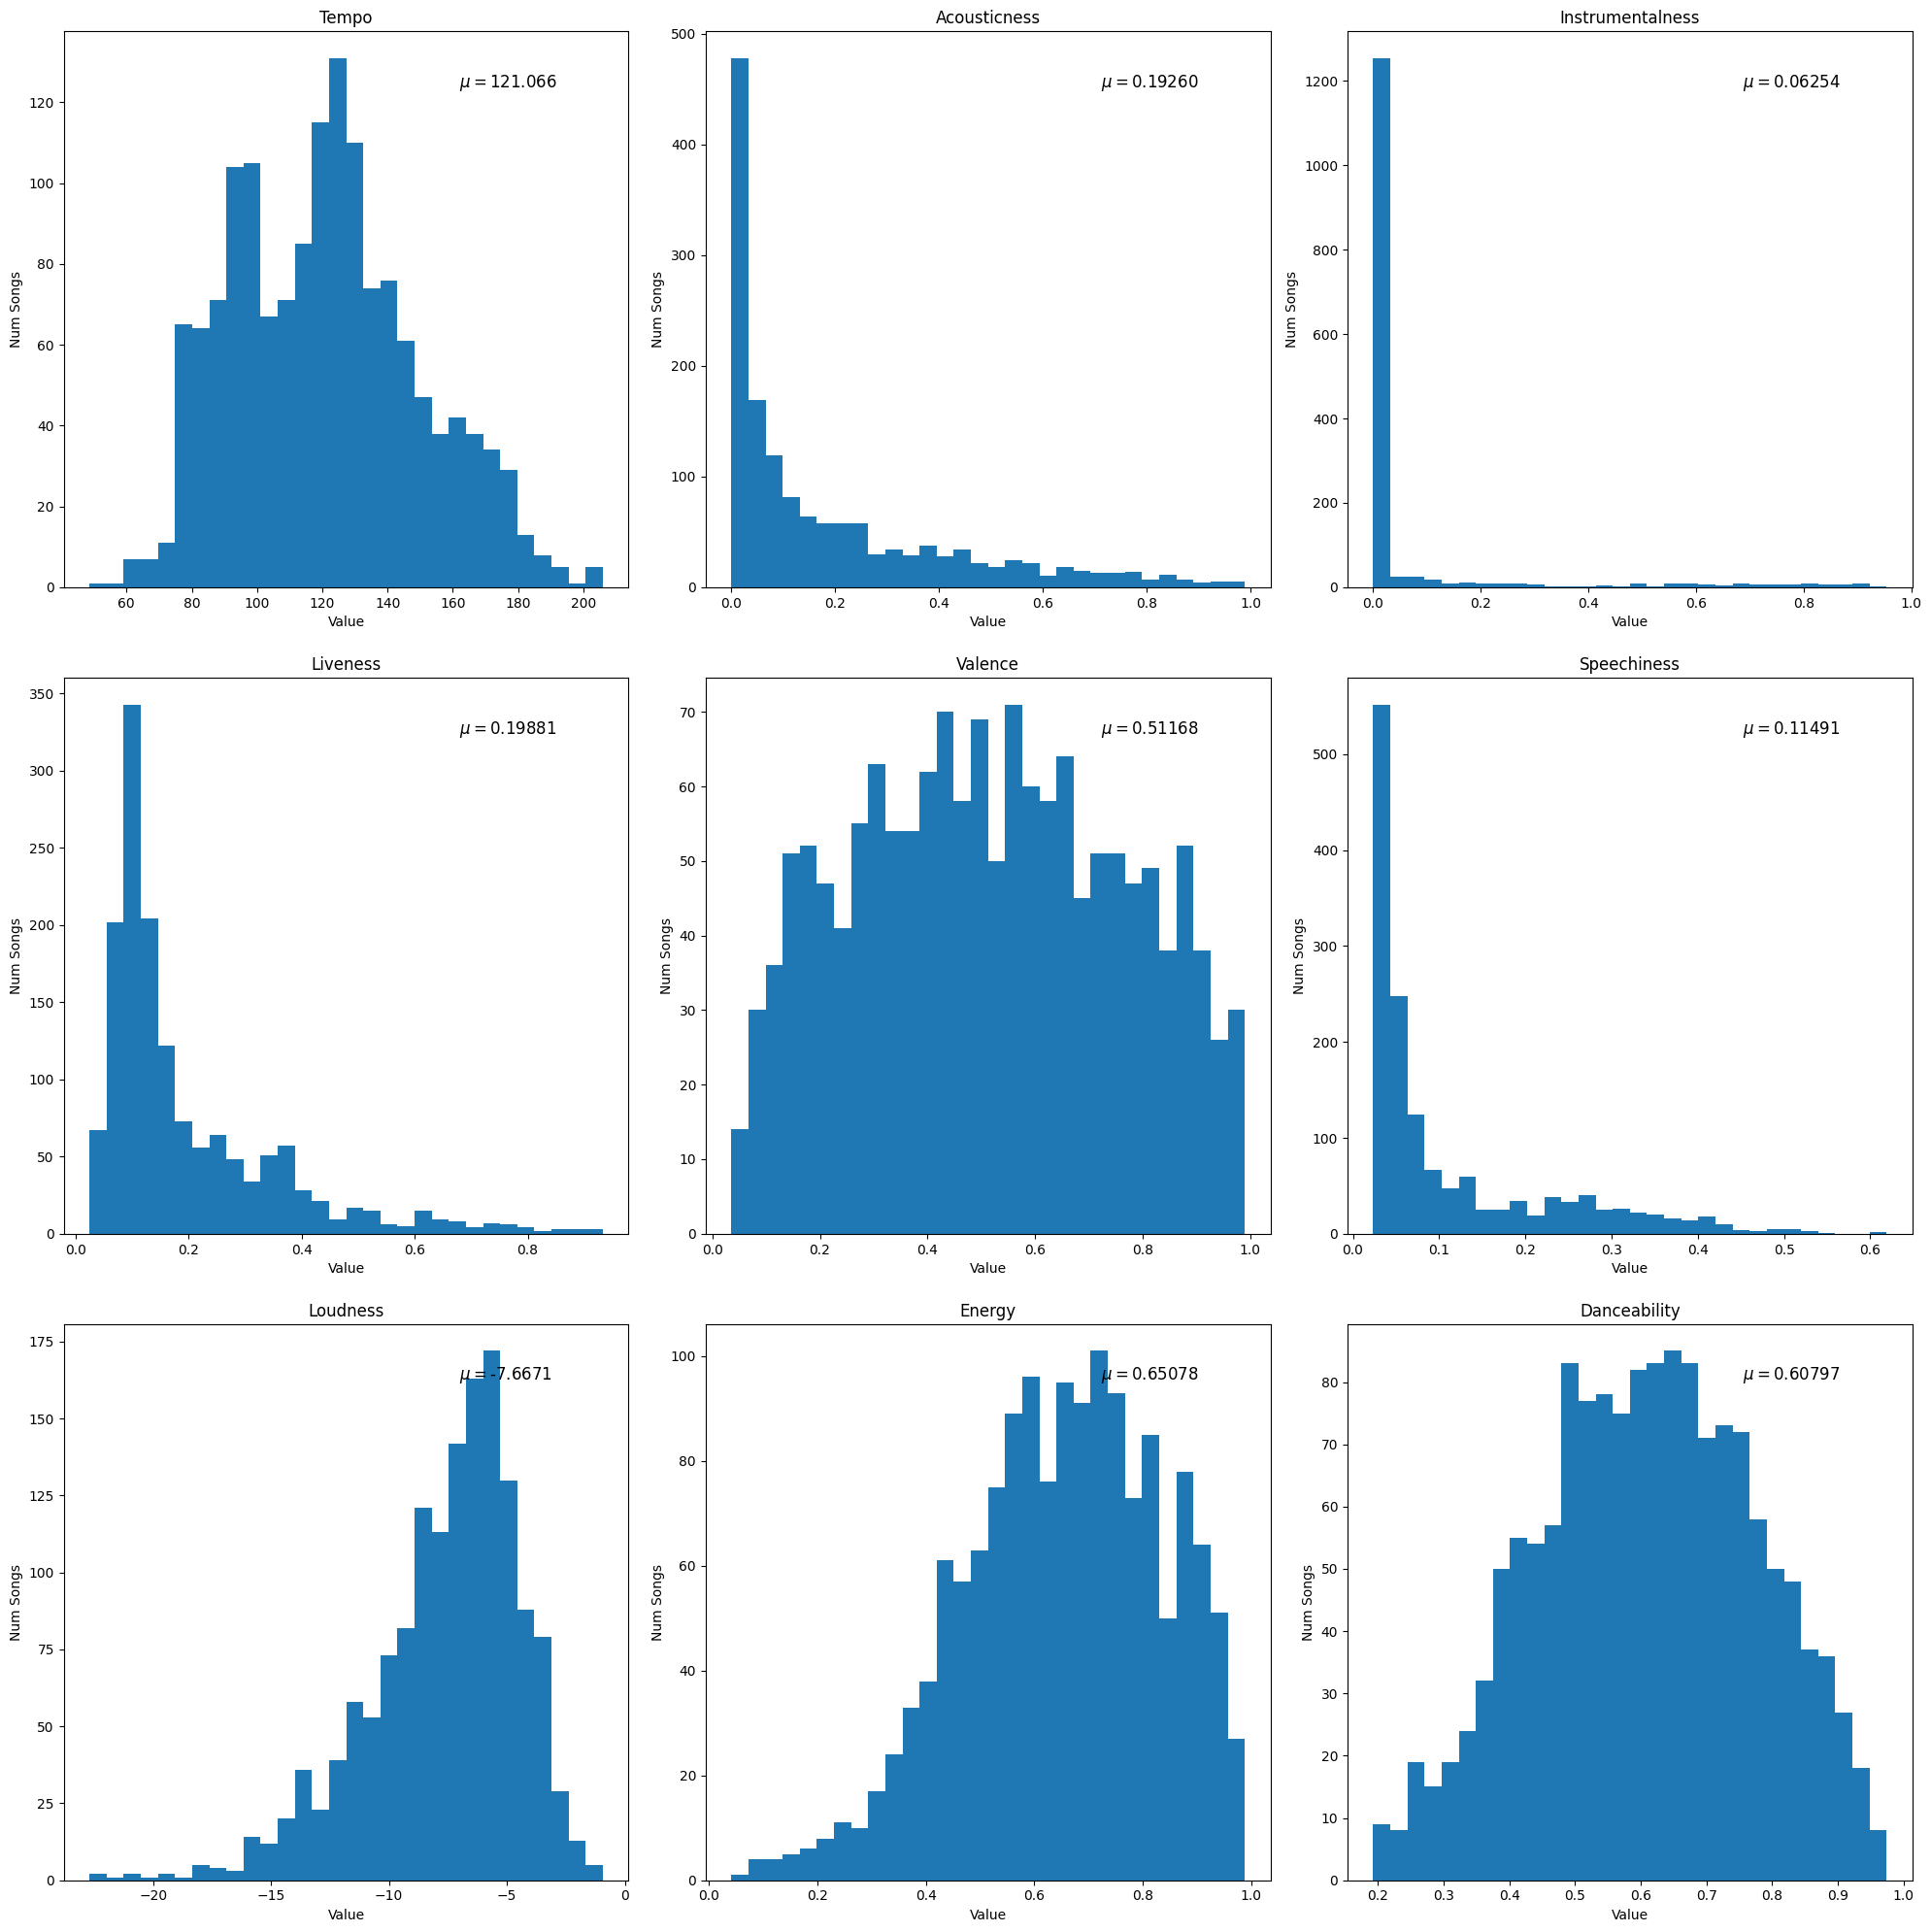

In [171]:
pyplot.figure(figsize=(20,20))

for i,category in enumerate(['Tempo', 'Acousticness', 'Instrumentalness', 'Liveness',
                            'Valence', 'Speechiness', 'Loudness', 'Energy', 'Danceability']):
    pyplot.subplot(3, 3, i+1)
    pyplot.hist(data[category], bins=30)
    pyplot.text(pyplot.xlim()[1] - (pyplot.xlim()[1] - pyplot.xlim()[0])*0.3,
                pyplot.ylim()[1]*0.9, r'$\mu=$'+str(data[category].mean())[:7], fontsize=12)
    pyplot.xlabel('Value')
    pyplot.ylabel('Num Songs')
    pyplot.title(category)

pyplot.tight_layout(h_pad=2)

For discrete music features:

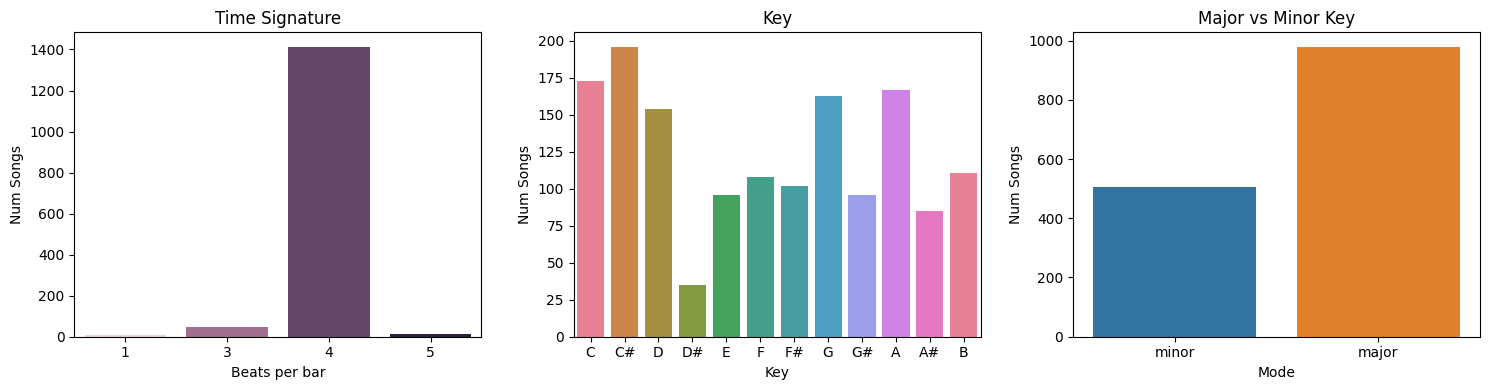

In [172]:
pyplot.figure(figsize=(15,4))

pyplot.subplot(1, 3, 1)
seaborn.countplot(data, x='Time Signature', hue='Time Signature', legend=False)
pyplot.xlabel('Beats per bar')
pyplot.ylabel('Num Songs')
pyplot.title('Time Signature')

pyplot.subplot(1, 3, 2)
seaborn.countplot(data, x='Key', hue='Key', palette='husl', legend=False)
pyplot.xticks(ticks=pyplot.xticks()[0], labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
pyplot.ylabel('Num Songs')
pyplot.title('Key')

pyplot.subplot(1, 3, 3)
seaborn.countplot(data, x='Mode', hue='Mode', legend=False)
pyplot.xticks(ticks=pyplot.xticks()[0], labels=['minor', 'major'])
pyplot.ylabel('Num Songs')
pyplot.title('Major vs Minor Key');

pyplot.tight_layout(w_pad=2)

In [173]:
print('5:\n', data.loc[data['Time Signature']==5][
    ['Track Name', 'Artist Name(s)', 'Release Date']][:20])

5:
                           Track Name  \
299                     Mrs. Officer   
335                          Roll Up   
400                              oui   
488                          Element   
542                       1942 Flows   
697                      Video Games   
724                           PRBLMS   
1112                         Monster   
1123                         Glitter   
1200                    Marvins Room   
1240            Kids Turned Out Fine   
1245                        CAROUSEL   
1330  100 Shooters (feat. Meek Mill)   
1457                 Me Or The Papes   

                                       Artist Name(s) Release Date  
299                      Lil Wayne,Bobby V.,Kidd Kidd   2008-06-10  
335                                       Wiz Khalifa   2011-03-29  
400                                           Jeremih   2015-12-04  
488                                         Pop Smoke   2020-02-07  
542                                         Meek M

In [174]:
print('0:\n', data.loc[data['Time Signature']==0][
    ['Track Name', 'Artist Name(s)', 'Release Date']][:10])
print('\n1:\n', data.loc[data['Time Signature']==1][
    ['Track Name', 'Artist Name(s)', 'Release Date']][:20])

0:
 Empty DataFrame
Columns: [Track Name, Artist Name(s), Release Date]
Index: []

1:
                                          Track Name  \
274                                   Touch The Sky   
534                                 Ghetto Symphony   
674                                     Ultramarine   
684                                      Drive Slow   
838                                           Woman   
887            Fire on the Mountain - 2013 Remaster   
912      Lucy In The Sky With Diamonds - Remastered   
1180                                          Money   
1351  Wishing For A Hero (feat. BJ The Chicago Kid)   
1361                                          Shine   

                    Artist Name(s) Release Date  
274         Kanye West,Lupe Fiasco   2005-08-30  
534   A$AP Rocky,Gunplay,A$AP Ferg   2013-01-11  
674                  Michael Brook   1992-06-01  
684       Kanye West,Paul Wall,GLC   2005-01-01  
838                     Wolfmother   2006-01-01  
887    

## Joint Analysis

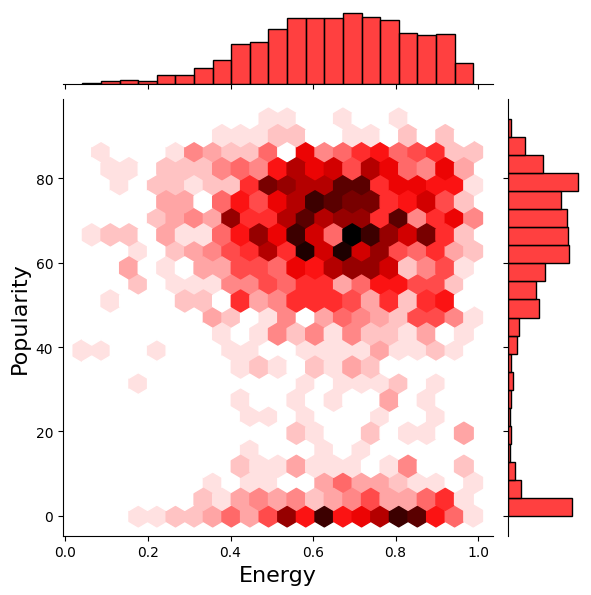

In [175]:
x = 'Energy'
y = 'Popularity'
axes = seaborn.jointplot(x=data[x], y=data[y], kind='hex', color='r')
axes.set_axis_labels(x, y, fontsize=16);

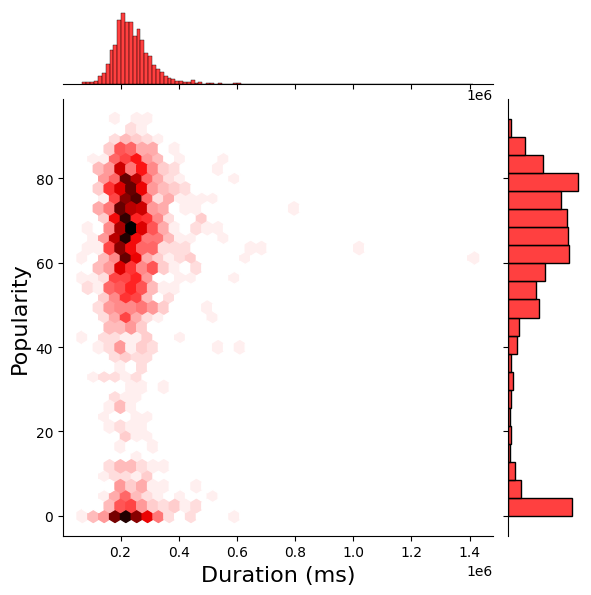

In [176]:
x = 'Duration (ms)'
y = 'Popularity'
axes = seaborn.jointplot(x=data[x], y=data[y], kind='hex', color='r')
axes.set_axis_labels(x, y, fontsize=16);

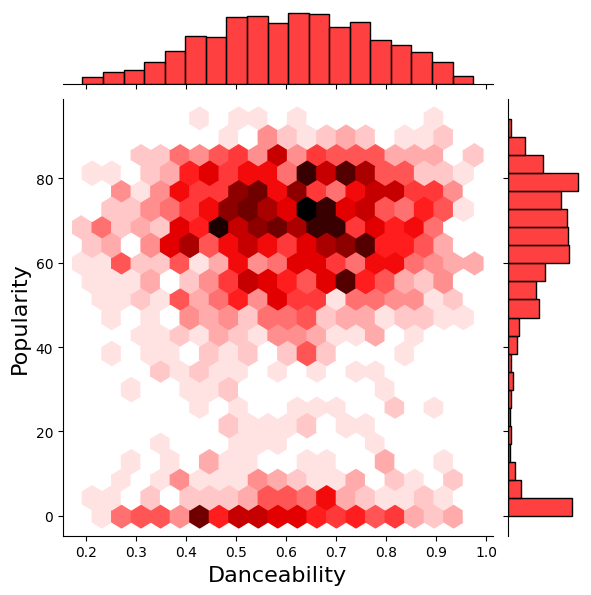

In [177]:
x = 'Danceability'
y = 'Popularity'
axes = seaborn.jointplot(x=data[x], y=data[y], kind='hex', color='r')
axes.set_axis_labels(x, y, fontsize=16);

## The Final Frontier

Finally, I'm going to follow [this guy's example](https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3) and feed the dimension-reduced data to a one-class SVM to get a sense of what the frontier of my normal taste looks like in that space, [heat-map-of-the-universe-style](https://www.nasa.gov/mission_pages/planck/multimedia/pia16873.html).

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a method for visualizing high-dimensional data in low-dimension. Songs which are more alike will be nearer each other in the feature space, but we can't visualize a space with that many dimensions. What we can do is reconstitute the points in 2D, attempting to preserve the pairwise distances, the notions of similarity, between songs.

using: ['Release Date', 'Duration (ms)', 'Popularity', 'Explicit', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature']


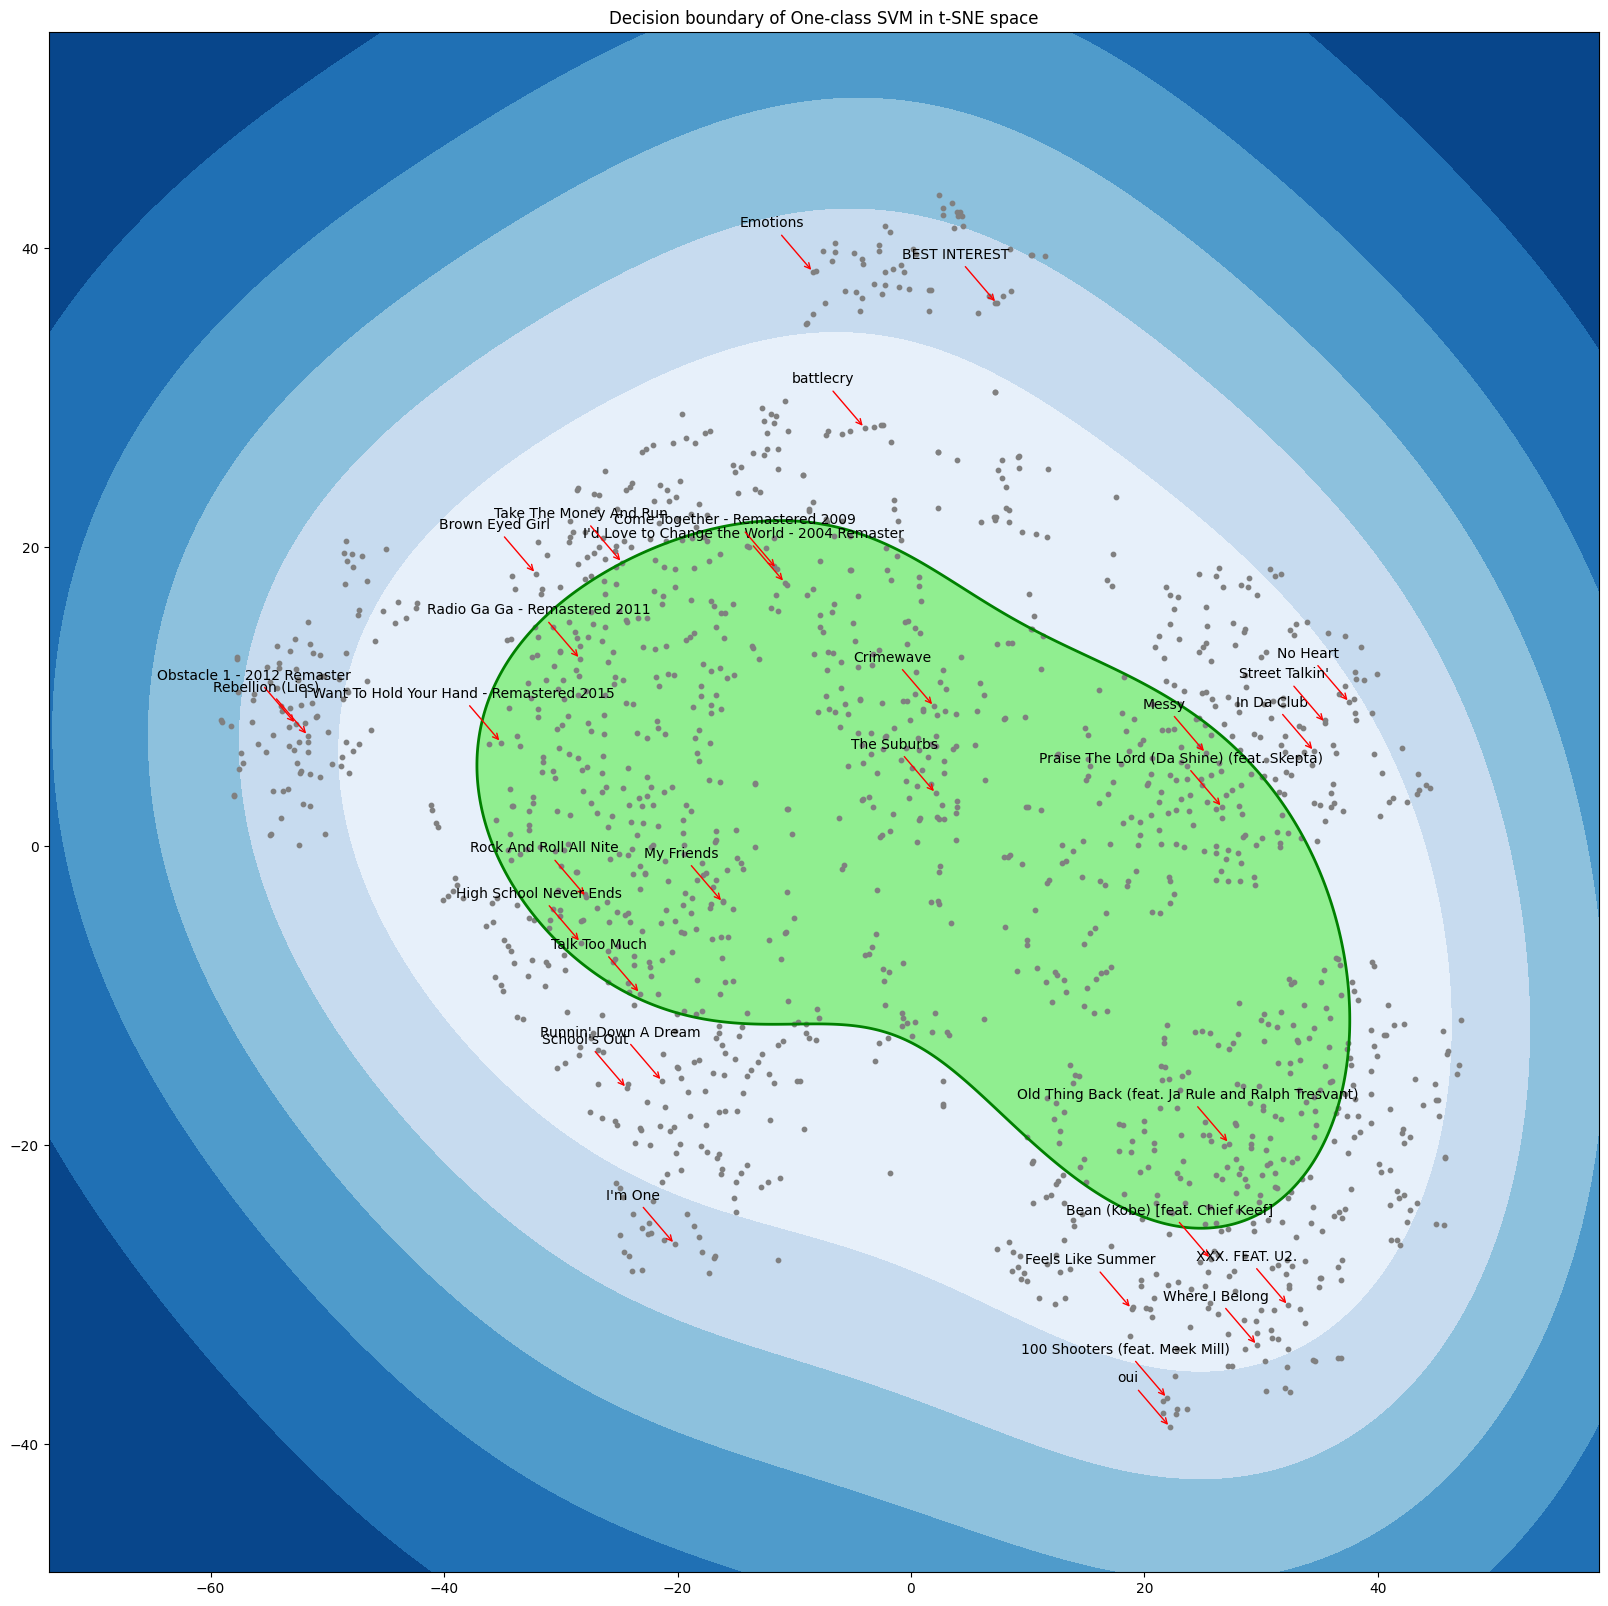

In [189]:
show_percent = 2

from sklearn.manifold import TSNE
from random import random
from sklearn.svm import OneClassSVM
import numpy

# Create a dataframe of only the numerical features, all normalized so embedding
# doesn't get confused by scale differences
numerical_data = data.drop(['Track URI', 'Track Name',
        'Album Name', 'Artist Name(s)', 'Added By', 'Added At',
        'Genres', 'Record Label'], axis=1)

numerical_data['Release Date'] = pandas.to_numeric(
    numerical_data['Release Date'].str.slice(0, 4))

numerical_data = (numerical_data - numerical_data.mean())/numerical_data.std()

print('using:', list(numerical_data.columns))

# If you like, only include a subset of these, because the results with all
# is really hard to interpret
#tsne_data = numerical_data[['Popularity', 'Energy', 'Acousticness',
#                                'Valence', 'Loudness']]
#print("\nConsidering similarity with respect to the following features:")
#print(tsne_data.dtypes)

# Takes a 2D data embedding and an svm trained on it and plots the decision boundary
def plotFrontier(embedded, svm, technique_name, scale):
    # get all the points in the space, and query the svm on them
    xx, yy = numpy.meshgrid(numpy.linspace(min(embedded[:,0])*scale,
                                           max(embedded[:,0])*scale, 500),
                            numpy.linspace(min(embedded[:,1])*scale,
                                           max(embedded[:,1])*scale, 500))
    Z = svm.decision_function(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # positive Z means yes. negative means outliers.

    pyplot.figure(figsize=(20,20))
    pyplot.title('Decision boundary of One-class SVM in '+technique_name+' space')
    pyplot.contourf(xx, yy, Z, levels=numpy.linspace(Z.min(), 0, 7), cmap=pyplot.cm.Blues_r)
    pyplot.contour(xx, yy, Z, levels=[0], linewidths=2, colors='green') # the +/- boundary
    pyplot.contourf(xx, yy, Z, levels=[0, Z.max()], colors='lightgreen')

    pyplot.scatter(embedded[:, 0], embedded[:, 1], s=10, c='grey')
    for i,song in data.iterrows():
        if random() < show_percent*0.011: # randomly label % of points
        # if song['Artist Name(s)'] in ['Pink Floyd', 'Frank Ocean']:
            x, y = embedded[i]
            pyplot.annotate(song['Track Name'], (x,y), size=10,
                xytext=(-30,30), textcoords='offset points',
                ha='center',va='bottom',
                arrowprops={'arrowstyle':'->', 'color':'red'})

tsne_embedded = TSNE(n_components=2).fit_transform(numerical_data)

svm_tsne = OneClassSVM(gamma='scale')
svm_tsne.fit(tsne_embedded)

plotFrontier(tsne_embedded, svm_tsne, 't-SNE', 1.25)

The point scatter looks really different every time this runs, because it's stochastic. The clusters don't necessarily have sensible interpretations, though you might be able to label a few of them. It's good to see some notionally similar pieces ending up near each other. You can try this with a subset of these dimensions to try to make the result more interpretable.

Modifying the parameters of the SVM changes its fit significantly, so I'm not sure this is the best model. Gamma too large just clearly overfits the data. Gamma too small just makes the decision boundary a boring ellipse. Using gamma='scale' as [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) recommend is a more interesting middle ground, but still the SVM seems to believe that a great many of the songs I love fall outside the boundary.

I'll try a different dimensionality reduction technique. The [original author](https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3) uses Principle Component Analysis to feed the SVM.

% variance explained by successive PCA dimensions: [0.1662979 0.1317221]


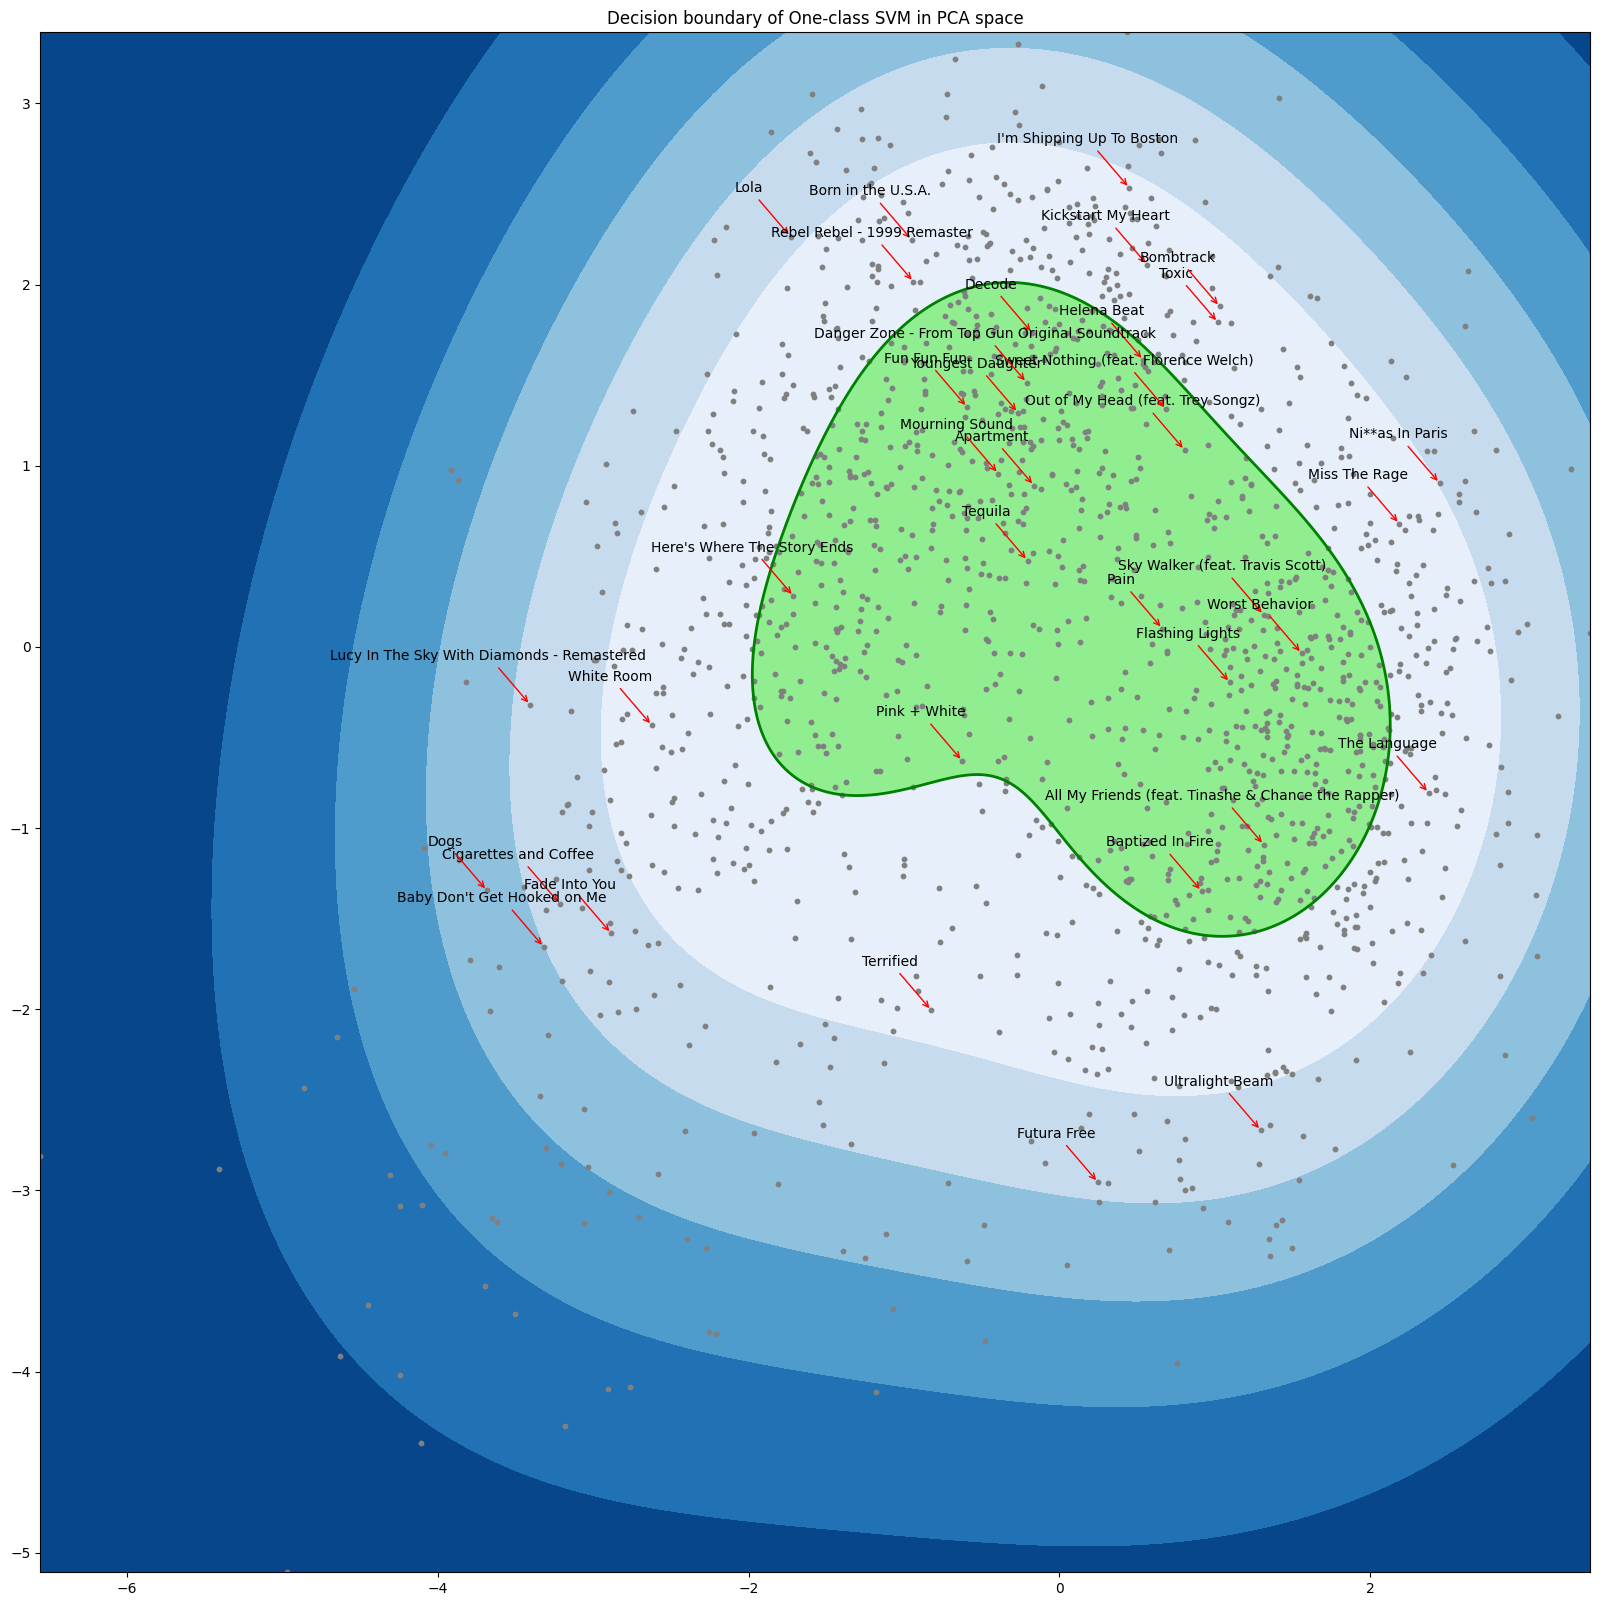

In [190]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embedded = pca.fit_transform(numerical_data)
print("% variance explained by successive PCA dimensions:",
      pca.explained_variance_ratio_)

svm_pca = OneClassSVM(gamma='scale')
svm_pca.fit(pca_embedded)

plotFrontier(pca_embedded, svm_pca, 'PCA', 1)

Ideally, songs falling nearer the center here, like Cheeseburger in Paradise and RAC's We Belong, are those that most characterize my taste numerically, and the odd ones, like Pink Floyd's Comfortably Numb and The Fellowship of the Ring orchestral suite, fall on the outside.

So in the end my music taste is a blob that doesn't even fit the data very well. And that's the point: Like many things, it's too complicated to boil down. You can't answer the question fully. But understanding elements of the answer can aid the process of discovery, and that's valuable. It's why Spotify is such a force at music recommendation. It's why Data Science.